In [1]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil, os, random,cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split, KFold

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# **1. Descargar y preparar conjunto de datos**

### Funciones anónimas para obtener las categorías de cada imágen

In [3]:
isStego=lambda x:1 if x[:6]=="stego_" else 0
getYFromImageList=lambda x: [isStego(element) for element in x]

In [4]:
dirs= [x[0] for x in os.walk("./readySamples/S-Uniward_50-50_05")]

### Orden aleatorio del dataset

In [5]:
images=os.listdir(dirs[0])
random.shuffle(images)

### Obteniendo las categorías

In [6]:
y=np.array(getYFromImageList(images))

In [7]:
y.shape

(89559,)

In [8]:
y

array([0, 1, 1, ..., 0, 0, 1])

In [9]:
y=y[:50000]

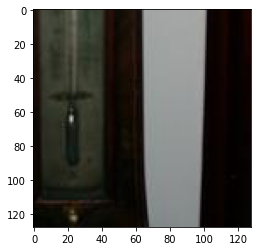

In [10]:
plt.imshow(plt.imread("./readySamples/S-Uniward_50-50_05/"+images[15]))

### Obteniendo data de x

In [11]:
import time

# Acá se usan 30GB de memoria (?) algo raro está pasando, de pronto hay que convertirlo a np array en otra línea. List comprehension usa mucha memoria...

In [12]:
t = time.time()
#.reshape(49152)
#/255,dtype='int8'
#Editar tamaño de muestra
x=np.array([cv2.imread("./readySamples/S-Uniward_50-50_05/"+images[i]) for i in range(50000)],dtype="float32")
elapsed = time.time() - t
print(elapsed)

158.451491355896


t = time.time()
x=x.reshape(len(x),49152)
elapsed += time.time() - t
print(elapsed)

In [13]:
import gc
gc.enable()
gc.collect()
gc.garbage

[]

In [14]:
from sys import getsizeof

In [15]:
getsizeof(x)

9830400144

In [16]:
print(x.shape)

(50000, 128, 128, 3)


#Aqeuí realizar el cálculo del tiempo con los diferentes métodos (.append, con diccionario, con list comprehension, con reshape directamente, sin reshape)

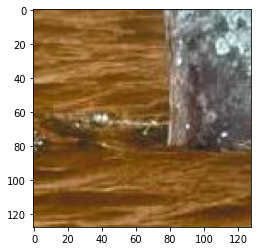

In [17]:
test=x[0]
plt.imshow(test.astype(np.int))

### Dividiendo entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

#reshape data to fit model
X_train = X_train.reshape(71647,128,128,3)
X_test = X_test.reshape(17912,128,128,3)

# **3. Base Convolucional**

In [18]:
# Custom filter
def high_pass(shape, dtype=None):
    f = np.zeros(shape, dtype='float16')
    f[:,:,0,0] = np.array([
            [ -1,  2 ,  -2,  2 ,  -1],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -2,  8 , -12,  8 ,  -2 ],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -1,  2 ,  -2,  2 ,  -1]
        ],dtype = 'float')
    f/=12    
    return K.variable(f, dtype='float16')

In [19]:
kfold = KFold(n_splits=5, shuffle=True)
acc_per_fold = []
loss_per_fold = []

In [20]:
x.shape

(50000, 128, 128, 3)

# Acá también se usa mucha memoria

In [21]:
#Setting early stopping
earlystopping=callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=5,restore_best_weights=True)
#Conv
fold_no = 1
for train, test in kfold.split(x, y[:len(x)]):
    model = models.Sequential()
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128,(5,5), padding='valid',strides=[1, 1],kernel_initializer=high_pass,
                          input_shape=(128, 128, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
    #Dense
    model.add(layers.Flatten())#, activation='relu'
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    #Comp
    model.compile(optimizer='sgd',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy',f1_m,precision_m, recall_m])
        # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    #Fitting
    history = model.fit(x[train], y[train],validation_data=(x[test], y[test]), epochs=50, callbacks=[earlystopping],batch_size=128)
    print("\n\n\n\n\nFitted")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    test_loss, test_acc,f1_score, precision, recall = model.evaluate(x[test], y[test], verbose=2)
    print("Loss:",test_loss, "\nAccuracy:",test_acc,"\nF1 score:",f1_score, "\nPrecision:",precision, "\nRecall",recall)
        
    plt.plot(history.history['precision_m'], label='precision')
    plt.plot(history.history['recall_m'], label = 'recall')
    plt.plot(history.history['f1_m'], label = 'F1')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.legend(loc='lower right')
    plt.show()
    print("Next fold")
    # Generate generalization metrics
    scores = model.evaluate(x[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50


ValueError: in user code:

    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1008 __call__
        self._maybe_build(inputs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2710 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/keras/layers/convolutional.py:205 build
        dtype=self.dtype)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:639 add_weight
        caching_device=caching_device)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/training/tracking/base.py:810 _add_variable_with_custom_getter
        **kwargs_for_getter)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:142 make_variable
        shape=variable_shape if variable_shape else None)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:260 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:221 _variable_v1_call
        shape=shape)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3332 creator
        return next_creator(**kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3332 creator
        return next_creator(**kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3332 creator
        return next_creator(**kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:714 variable_capturing_scope
        lifted_initializer_graph=lifted_initializer_graph, **kwds)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:234 __init__
        name="initial_value", dtype=dtype)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1540 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1992 _dense_var_to_tensor
        return var._dense_var_to_tensor(dtype=dtype, name=name, as_ref=as_ref)  # pylint: disable=protected-access
    /home/stegian-admin/.local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1389 _dense_var_to_tensor
        "of type {!r}".format(dtype.name, self.dtype.name))

    ValueError: Incompatible type conversion requested to type 'float32' for variable of type 'float16'


In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

#model.build((None,128,128,3))
model.summary()

# **4. Agregar capas densas en la parte superior**

In [ ]:
model.summary()

# **5. Compilar y entrenar el modelo**



In [ ]:
model.save("CNNv2.h5")

# **6. Evaluar el modelo**